In [1]:

# visualize regimes


import pandas as pd
import numpy as np

# ===== 1) Load & clean =====

path = "/Users/kim/Desktop/Quant-Research/data/raw/SPY_2015_2025.csv" # 文件路径
raw = pd.read_csv(path)

# 你的csv第一列叫 "Price"，但第1行其实是"Date"占位，需要清掉
df = raw[raw["Price"] != "Date"].copy()

# parse date
df["Date"] = pd.to_datetime(df["Price"], errors="coerce")
df = df.drop(columns=["Price"])

# numeric columns
for c in ["Close", "Open", "High", "Low", "Volume"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# sort & set index
df = df.sort_values("Date").dropna(subset=["Date", "Close"]).reset_index(drop=True)
df = df.set_index("Date")

# ===== 2) Returns & rolling stats =====
df["ret"] = df["Close"].pct_change() # .pct_change()：计算每日 simple return

# rolling vol (annualized)
TRADING_DAYS = 252
df["vol_60d"]  = df["ret"].rolling(60).std()  * np.sqrt(TRADING_DAYS)
df["vol_120d"] = df["ret"].rolling(120).std() * np.sqrt(TRADING_DAYS)

# rolling return (annualized, simple approximation)
df["ann_ret_60d"]  = df["ret"].rolling(60).mean()  * TRADING_DAYS
df["ann_ret_120d"] = df["ret"].rolling(120).mean() * TRADING_DAYS

# ===== 3) Drawdown =====
df["cum"] = (1 + df["ret"].fillna(0)).cumprod()
df["peak"] = df["cum"].cummax()
df["dd"] = df["cum"] / df["peak"] - 1.0  # drawdown (<=0)

# (optional) log price for nicer plots
df["log_close"] = np.log(df["Close"])

df.head()


,Close,High,Low,Open,Volume,ret,vol_60d,vol_120d,ann_ret_60d,ann_ret_120d,cum,peak,dd,log_close
Date,,,,,,,,,,,,,,
2015-01-02,170.589630,171.793724,169.551627,171.378523,121465900.0,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,5.139261
2015-01-05,167.508881,169.709443,167.201636,169.543365,169632600.0,-0.018059,NaN,NaN,NaN,NaN,0.981941,1.000000,-0.018059,5.121036
2015-01-06,165.931076,168.339239,165.133884,167.816081,209151400.0,-0.009419,NaN,NaN,NaN,NaN,0.972691,1.000000,-0.027309,5.111572
2015-01-07,167.998718,168.339186,166.811249,167.259661,125346700.0,0.012461,NaN,NaN,NaN,NaN,0.984812,1.000000,-0.015188,5.123956
2015-01-08,170.979904,171.195817,169.393845,169.410444,147217800.0,0.017745,NaN,NaN,NaN,NaN,1.002288,1.002288,0.000000,5.141546


In [2]:
subsamples = {
    "2015-2017": ("2015-01-02", "2017-12-29"),   # post-GFC recovery / sideways
    "2018-2019": ("2018-01-02", "2019-12-31"),   # vol spikes + pre-covid
    "2020-2021": ("2020-01-02", "2021-12-31"),   # covid crash + QE bull
    "2022":      ("2022-01-03", "2022-12-30"),   # rate-hike bear
    "2023-2025": ("2023-01-03", "2025-01-03"),   # recent regime
    "full":      ("2015-01-02", "2025-01-03"),
}

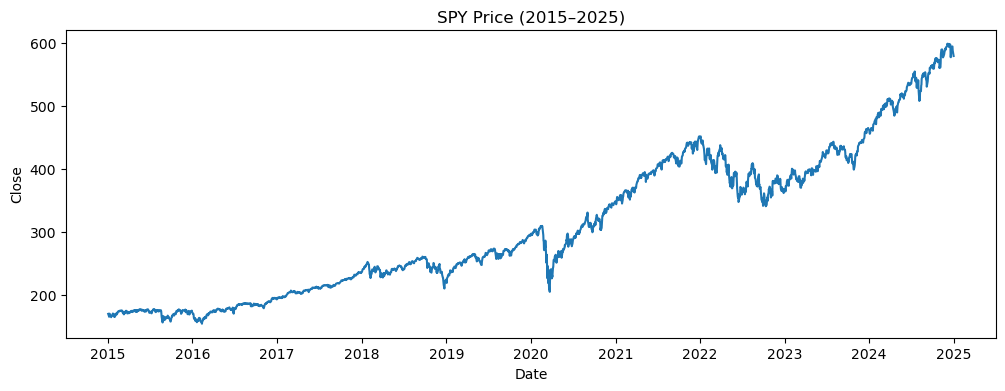

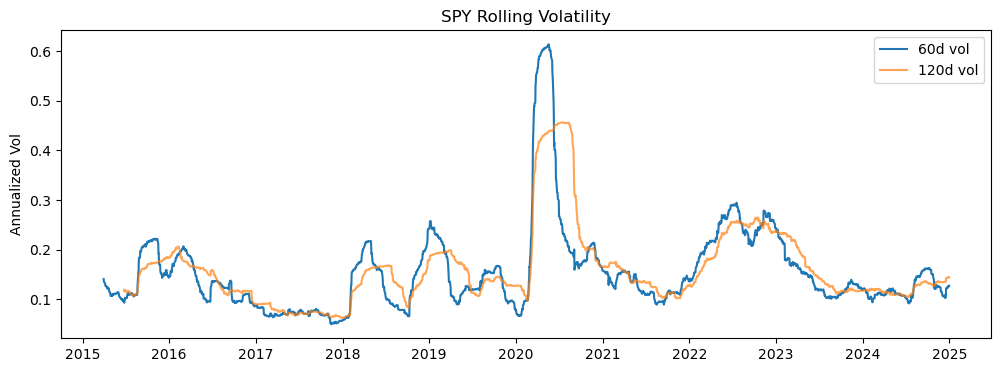

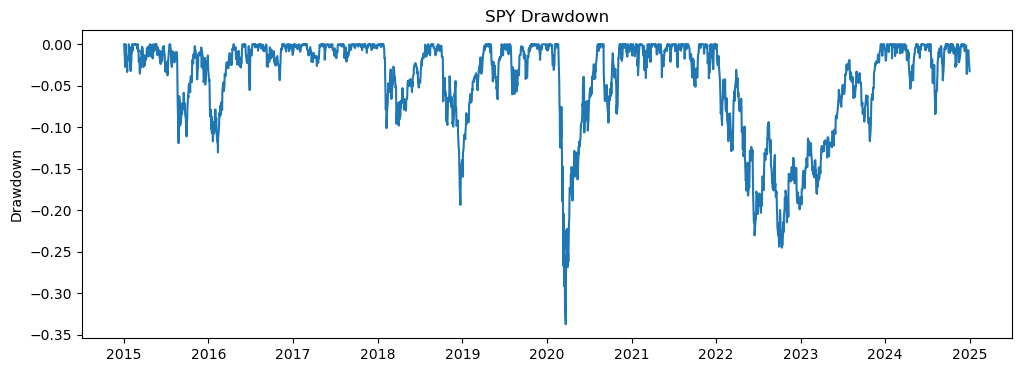

In [6]:
### 第一张必须画的图：Price（直觉中的“趋势”）

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df.index, df["Close"])
plt.title("SPY Price (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### 第二张：Rolling Vol（直觉中的“压力”）
plt.figure(figsize=(12,4))
plt.plot(df.index, df["vol_60d"], label="60d vol")
plt.plot(df.index, df["vol_120d"], label="120d vol", alpha=0.7)
plt.legend()
plt.title("SPY Rolling Volatility")
plt.ylabel("Annualized Vol")
plt.show()

### 第三张（非常重要）：Drawdown（risk-off 的直觉来源）
plt.figure(figsize=(12,4))
plt.plot(df.index, df["dd"])
plt.title("SPY Drawdown")
plt.ylabel("Drawdown")
plt.show()